<font color= #0cc754> <h1 align = "center">Customer Segmentation using RFM</h1>

## <font color= #0cc754> Table of CONTENTS </font>

1. [Introduction](#introduction)
2. [Library Imports](#Library-Imports)
3. [Cleaning and Exploratory Data Analysis (EDA)](#cleaning-and-eda)
4. [Segmentation using RFM](#segmentation-using-rfm)
5. [Visualization of Segments](#visualization-of-segments)


## <font color= #0cc754> Introduction </font> 

**Disclaimer: This cell is essentially a copy of the kaggle website that talks about the dataset**

### About Dataset

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

### Details

An e-commerce company wants to segment its customers and determine marketing strategies according to these segments. To this end, we will define the behavior of customers and create groups according to clusters in these behaviors. In other words, we will include those who exhibit common behaviors in the same groups and we will try to develop special sales and marketing techniques for these groups.


|  | **Feature Name**          | **Meaning**                                                                                |
|:---:|:------------------------|:------------------------------------------------------------------|
| 1   | InvoiceNo                    | Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.                                                                    |
| 2   | StockCode             | Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.                                                                                                                    |
| 3   | Quantity             | The quantities of each product (item) per transaction. Numeric.                              |
| 4   | Description          |    Product (item) name. Nominal.                                                             |
| 5   | InvoiceDate         | Invice date and time. Numeric. The day and time when a transaction was generated.                                                                                                                  |
| 6   | UnitPrice              | Customer's yearly household income                                                         |
| 7   | CustomerID               | Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.                                                                                                                   |
| 8   | Country            | Country name. Nominal. The name of the country where a customer resides.                       |



## <font color= #0cc754> Library Imports </font>

In [187]:
import numpy as np 
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage,dendrogram


import warnings
warnings.filterwarnings("ignore")

## <font color= #0cc754> Cleaning and Exploratory Data Analysis (EDA) </font>

In [188]:
path = "./data/"
df = pd.read_csv(path + 'online_retail_listing.csv', encoding= 'unicode_escape', sep = ';')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,"6,95",13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1.12.2009 07:45,"2,1",13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.12.2009 07:45,"1,25",13085.0,United Kingdom


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1048575 non-null  object 
 1   StockCode    1048575 non-null  object 
 2   Description  1044203 non-null  object 
 3   Quantity     1048575 non-null  int64  
 4   InvoiceDate  1048575 non-null  object 
 5   Price        1048575 non-null  object 
 6   Customer ID  811893 non-null   float64
 7   Country      1048575 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 64.0+ MB


From the above there are some things we have to do, like converting the `Price` column from an object into a float. Since they are using an ',' as a decimal, we need to change that as well.  

In [190]:
df['Price'] = df['Price'].str.replace(',', '.')
df['Price'] = df['Price'].astype(float)

Now let's see the NULL values

In [191]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4372
Quantity            0
InvoiceDate         0
Price               0
Customer ID    236682
Country             0
dtype: int64

As we can see from the above, `Customer ID` has a **LOT** of `NULL` values. Unfortunately they are essential for the analysis that will follow, so we will need to delete all of them. We will as well delete duplicate rows. 

In [192]:
df.dropna(subset=['Customer ID'], inplace=True)
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785599 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      785599 non-null  object 
 1   StockCode    785599 non-null  object 
 2   Description  785599 non-null  object 
 3   Quantity     785599 non-null  int64  
 4   InvoiceDate  785599 non-null  object 
 5   Price        785599 non-null  float64
 6   Customer ID  785599 non-null  float64
 7   Country      785599 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 53.9+ MB


We change as well the InvoiceDate into datetime and Customer ID into integers.

In [193]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Customer ID'] = df['Customer ID'].astype(int)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

An important feature is the Total spending (Quantity * Price), so we make a column for that.

In [194]:
df['Total_Spending'] = df['Quantity'] * df['Price']

In [195]:
# This is custom function to get the summary of the numeric columns
def numeric_summary(df):
    obs = df.shape[0]
    duplicate_count = df.duplicated().sum()
    
    df_numeric = df.select_dtypes(include='number')
    summary_df = pd.DataFrame({
        'Dtype': df_numeric.dtypes, 
        'Counts': df_numeric.apply(lambda x: x.count()), 
        'Nulls': df_numeric.apply(lambda x: x.isnull().sum()),
        'Min': df_numeric.min(),
        'Max': df_numeric.max(),
        'Uniques': df_numeric.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': df_numeric.apply(lambda x: list(x.unique()) if x.nunique() <= 10 else 'Too many')
    })
    
    # Display df.shape and duplicate count at the beginning
    print(f'1. Data shape (rows, columns): {df.shape}')
    print(f'2. Number of duplicate rows: {duplicate_count}')
    
    return summary_df

numeric_summary(df)

1. Data shape (rows, columns): (785599, 9)
2. Number of duplicate rows: 0


,Dtype,Counts,Nulls,Min,Max,Uniques,UniqueValues
Quantity,int64,785599,0,-74215.0,74215.0,636,Too many
Price,float64,785599,0,0.0,38970.0,1014,Too many
Customer ID,int32,785599,0,12346.0,18287.0,5924,Too many
Total_Spending,float64,785599,0,-77183.6,77183.6,5563,Too many


An interesting thing from above is the fact that there are negative values for the `Quantity` Attribute, most likely due to cancelations. Indeed: 

In [196]:
cancellations = df[df['Invoice'].str.startswith('C')]
cancellations['Quantity'].max()

-1

It is fair to exclude all orders that are cancelations, since they shouldn't come into our analysis at this point.

In [197]:
df = df[~df['Invoice'].str.startswith('C')]
numeric_summary(df)

1. Data shape (rows, columns): (767439, 9)
2. Number of duplicate rows: 0


,Dtype,Counts,Nulls,Min,Max,Uniques,UniqueValues
Quantity,int64,767439,0,1.0,74215.0,432,Too many
Price,float64,767439,0,0.0,10953.5,660,Too many
Customer ID,int32,767439,0,12346.0,18287.0,5863,Too many
Total_Spending,float64,767439,0,0.0,77183.6,3874,Too many


In [198]:
# This is custom function to get the summary of the object columns
def object_summary(df):
    obs = df.shape[0]
    duplicate_count = df.duplicated().sum()
    
    object_df = df.select_dtypes(include='object')
    summary_df = pd.DataFrame({
        'Dtype': object_df.dtypes,
        'Counts': object_df.apply(lambda x: x.count()),
        'Nulls': object_df.apply(lambda x: x.isnull().sum()),
        'Top': object_df.apply(lambda x: x.mode()[0] if not x.mode().empty else '-'),
        'Frequency': object_df.apply(lambda x: x.value_counts().max() if not x.value_counts().empty else '-'),
        'Uniques': object_df.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': object_df.apply(lambda x: list(x.unique()) if x.nunique() <= 10 else 'Too many')
    })
    
    # Display df.shape and duplicate count at the beginning
    print(f'1. Data shape (rows, columns): {df.shape}')
    print(f'2. Number of duplicate rows: {duplicate_count}')
    
    return summary_df

object_summary(df)

1. Data shape (rows, columns): (767439, 9)
2. Number of duplicate rows: 0


,Dtype,Counts,Nulls,Top,Frequency,Uniques,UniqueValues
Invoice,object,767439,0,576339,542,36463,Too many
StockCode,object,767439,0,85123A,4982,4630,Too many
Description,object,767439,0,WHITE HANGING HEART T-LIGHT HOLDER,4982,5281,Too many
Country,object,767439,0,United Kingdom,689613,41,Too many


Now we make the Recency, Frequency and Monetary value for each customer, storing it in a new dataset.

In [199]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

dict_rfm = {
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'Total_Spending': 'sum'
}

rfm = df.groupby('Customer ID').agg(dict_rfm).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346,327,34,77556.46
1,12347,41,211,4696.71
2,12348,77,51,2019.40
3,12349,20,175,4428.69
4,12350,312,17,334.40


In [200]:
numeric_summary(rfm)

1. Data shape (rows, columns): (5863, 4)
2. Number of duplicate rows: 0


,Dtype,Counts,Nulls,Min,Max,Uniques,UniqueValues
Customer ID,int64,5863,0,12346.0,18287.0,5863,Too many
Recency,int64,5863,0,1.0,1063.0,612,Too many
Frequency,int64,5863,0,1.0,12121.0,690,Too many
Monetary,float64,5863,0,0.0,569501.5,5759,Too many


So, we have a total of 5863 different customers. Let's make a vizualization of the distribution of each of these attributes.

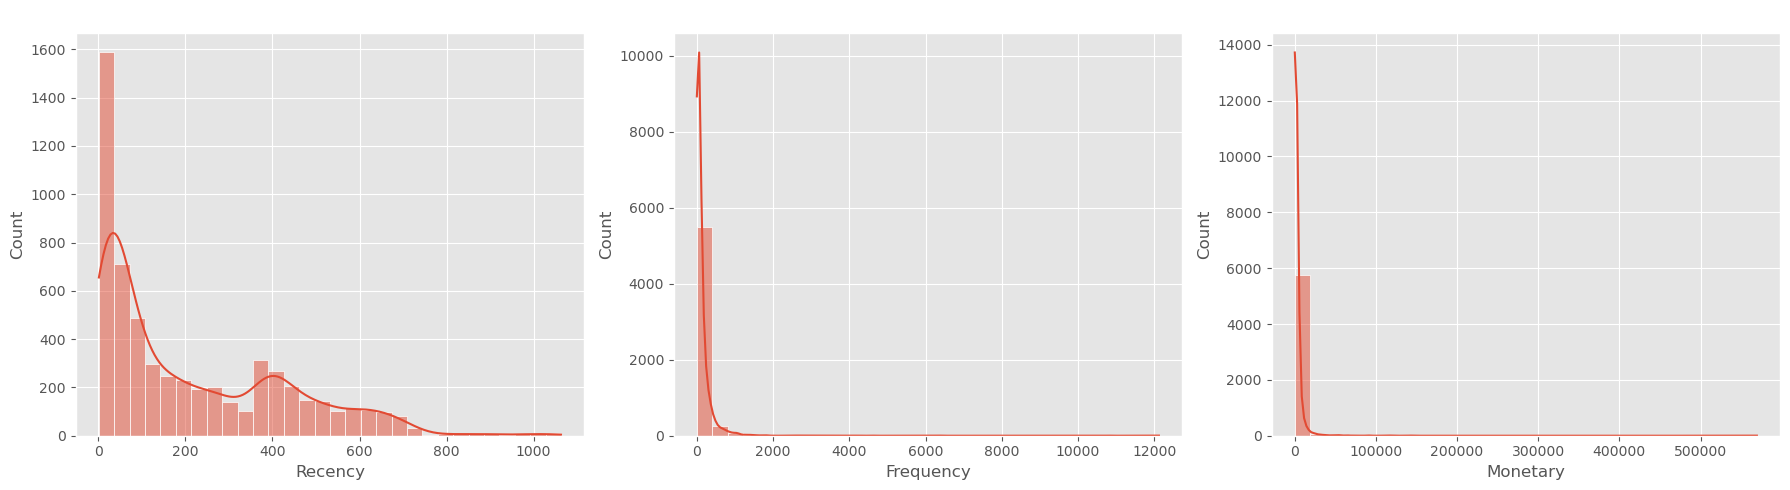

In [201]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.style.use('dark_background')

for i, col in enumerate(rfm.columns[1:]):
    sns.histplot(rfm[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

There seems to have some outliers in the frequency and monetary distributions, let's see the Boxplot.

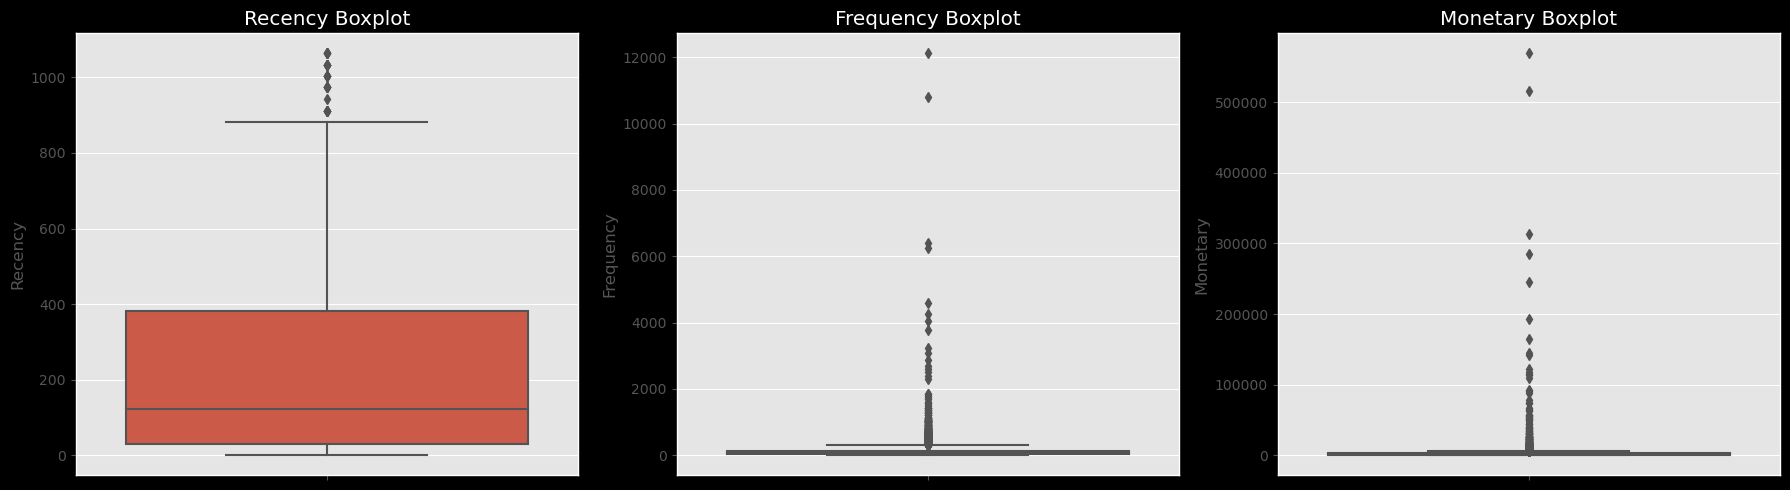

In [202]:
plt.figure(figsize=(18, 5))
plt.style.use('ggplot')
for i, col in enumerate(rfm.columns[1:], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=rfm[col])
    plt.title(f'{col} Boxplot')

plt.tight_layout()
plt.show()

Let's see the dataset without these outliers.

In [203]:
Q1 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.25)
Q3 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.75)
IQR = Q3 - Q1

condition = ~((rfm[['Recency', 'Frequency', 'Monetary']] < (Q1 - 1.5 * IQR)) | (rfm[['Recency', 'Frequency', 'Monetary']] > (Q3 + 1.5 * IQR))).any(axis=1)

rfm_no_outliers = rfm[condition]

print(f'Original dataset shape: {rfm.shape}')
print(f'Dataset shape after removing outliers: {rfm_no_outliers.shape}')

Original dataset shape: (5863, 4)
Dataset shape after removing outliers: (5000, 4)


Let's look at the distribution again without these outliers.

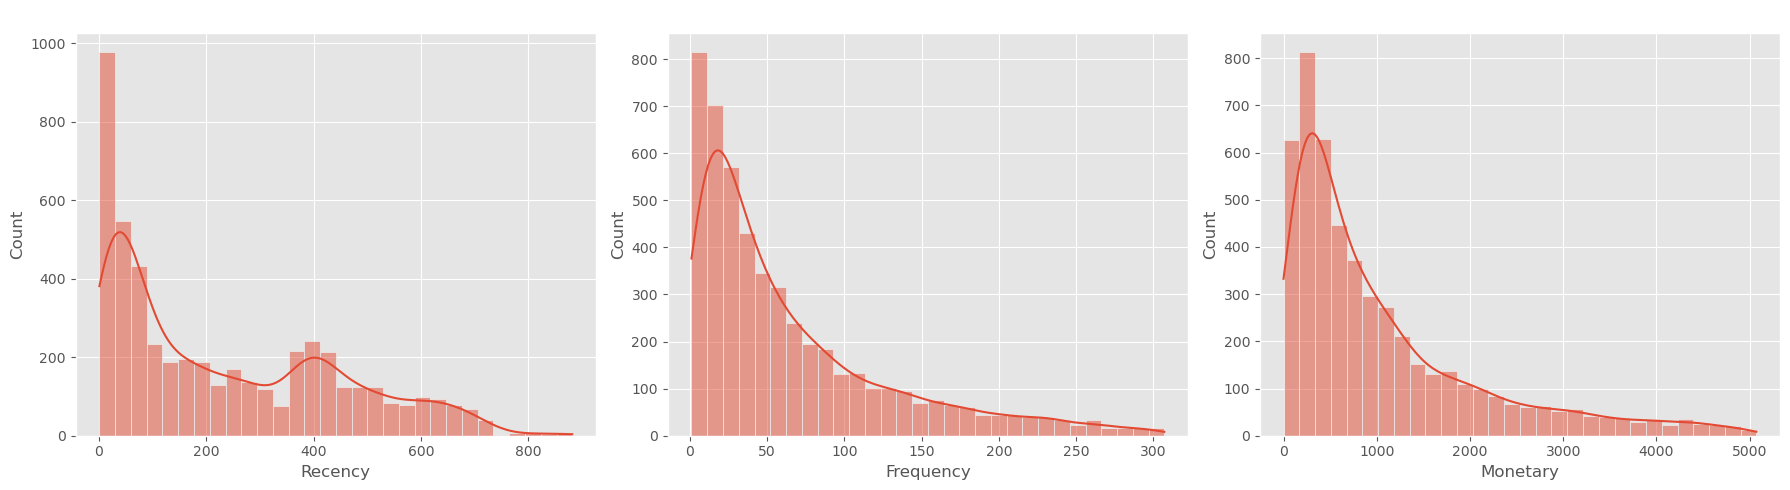

In [204]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(rfm_no_outliers.columns[1:]):
    sns.histplot(rfm_no_outliers[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

Now let's see the correlation matrix for the dataset without outliers.

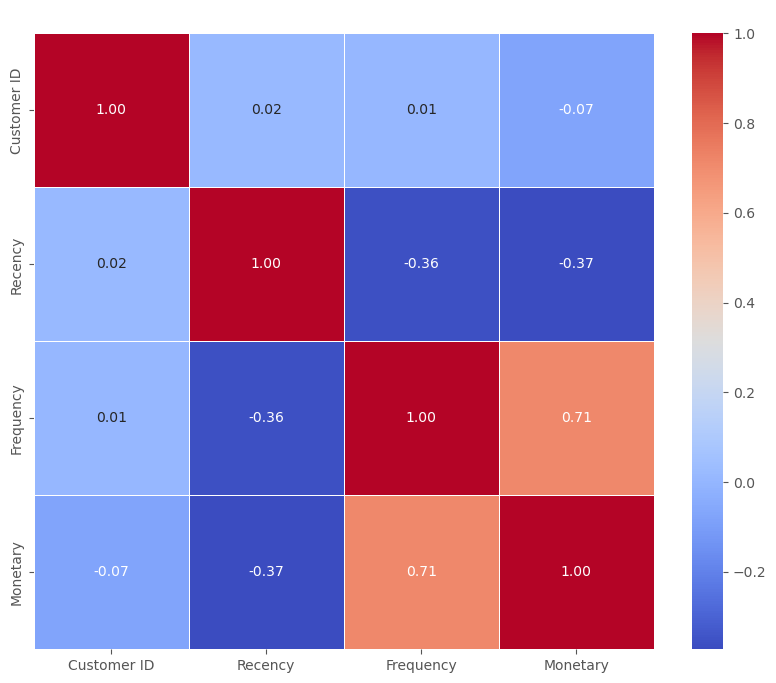

In [205]:
correlation_matrix = rfm_no_outliers.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of RFM Metrics')
plt.show()

We see a high correlation between monetary and frequency, as well as a small but noticiable negative correlation between recency and frequency; and recency and monetary.

## <font color= #0cc754> Segmentation using RFM </font>

Now we are going to segment our customers, we are going to see both the totallity of the customers and the one without the outliers.

In [206]:
def rfm_score(df):

    r_quartiles = pd.qcut(df['Recency'], 5, labels=[5, 4, 3, 2, 1])
    f_quartiles = pd.qcut(df['Frequency'].rank(method='first'),5,labels=[1, 2, 3, 4, 5])
    m_quartiles = pd.qcut(df['Monetary'].rank(method='first'),5,labels=[1, 2, 3, 4, 5])

    rfm_combined = pd.DataFrame({
        'Customer ID': df['Customer ID'],
        'R': r_quartiles,
        'F': f_quartiles,
        'M': m_quartiles
    })
    for i in ['R', 'F', 'M']:
        rfm_combined[i] = rfm_combined[i].astype(str)

    rfm_combined['RFM_Score'] = rfm_combined[['R', 'F', 'M']].sum(axis=1).astype(int).astype(str)
    return rfm_combined

rfm_segmented = rfm_score(rfm)
rfm_no_outliers_segmented = rfm_score(rfm_no_outliers)

rfm_segmented.head()

,Customer ID,R,F,M,RFM_Score
0,12346,2,2,5,225
1,12347,4,5,5,455
2,12348,3,3,4,334
3,12349,5,5,5,555
4,12350,2,2,2,222


There are many ways to segment the customers, I will use the one indicated in https://clevertap.com/blog/rfm-analysis/ considering only the R and F scores.

In [207]:
def segment_customers(rfm_df):
    segments = {
        r'^5[4-5].' : 'Champions',
        r'^[3-4][4-5].' : 'Loyal Customers',
        r'^[1-2]5.' : " Cant Lose them",
        r'^[1-2][3-4].' : 'At Risk',
        r'^[4-5][2-3].' : 'Potential Loyalists',
        r'^51.' : 'New Customers',
        r'^41.' : 'Promising',
        r'^33.' : 'Need Attention',
        r'^3[1-2].' : 'About to Sleep',
        r'^[1-2][1-2].' : 'Hibernating',
    }

    rfm_df['rfm_segment'] = rfm_df['RFM_Score'].replace(segments, regex = True)

    return rfm_df

rfm_segmented = segment_customers(rfm_segmented)
rfm_no_outliers_segmented = segment_customers(rfm_no_outliers_segmented)

## <font color= #0cc754> Visualization of Segments </font>

Now we see distribution of the segments we made.

In [208]:
segment_counts = rfm_segmented['rfm_segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

fig = px.bar(segment_counts, x='Segment', y='Count', title='Customer Segments Distribution', 
             labels={'Segment': 'Customer Segment', 'Count': 'Number of Customers'}, 
             color='Segment')

fig.show()

Without the outiliers the distribution looks like this

In [209]:
segment_counts_no_outlier = rfm_no_outliers_segmented['rfm_segment'].value_counts().reset_index()
segment_counts_no_outlier.columns = ['Segment', 'Count']

fig = px.bar(segment_counts_no_outlier, x='Segment', y='Count', title='Customer Segments Distribution', 
             labels={'Segment': 'Customer Segment', 'Count': 'Number of Customers'}, 
             color='Segment')

# Show the plot
fig.show()

In a pie chart the segments become

In [210]:
fig_with_outliers = px.pie(segment_counts, names='Segment', values='Count', title='Customer Segments Distribution (With Outliers)')
fig_with_outliers.show()

fig_without_outliers = px.pie(segment_counts_no_outlier, names='Segment', values='Count', title='Customer Segments Distribution (Without Outliers)')
fig_without_outliers.show()

And so we have identified our customers based on their Recency and Frequency values. What we can do with each segment is stated in, for example, https://clevertap.com/blog/rfm-analysis/

But we see that something should be done with the Hibernating customers, since it constitutes a plurarity of our customers.